# Received Power Optimization

In [2]:
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import tqdm, trange
from vispy.scene.visuals import Image
from vispy.visuals.transforms import STTransform

import differt.plotting as dplt
from differt.geometry import TriangleMesh
from differt.geometry.triangle_mesh import (
    triangles_contain_vertices_assuming_inside_same_plane,
)
from differt.rt.image_method import (
    consecutive_vertices_are_on_same_side_of_mirrors,
    image_method,
)
from differt.rt.utils import (
    generate_all_path_candidates_chunks_iter,
    rays_intersect_any_triangle,
    rays_intersect_triangles,
)

RFBOutputContext()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

CanvasBackend(css_height='600px', css_width='800px')
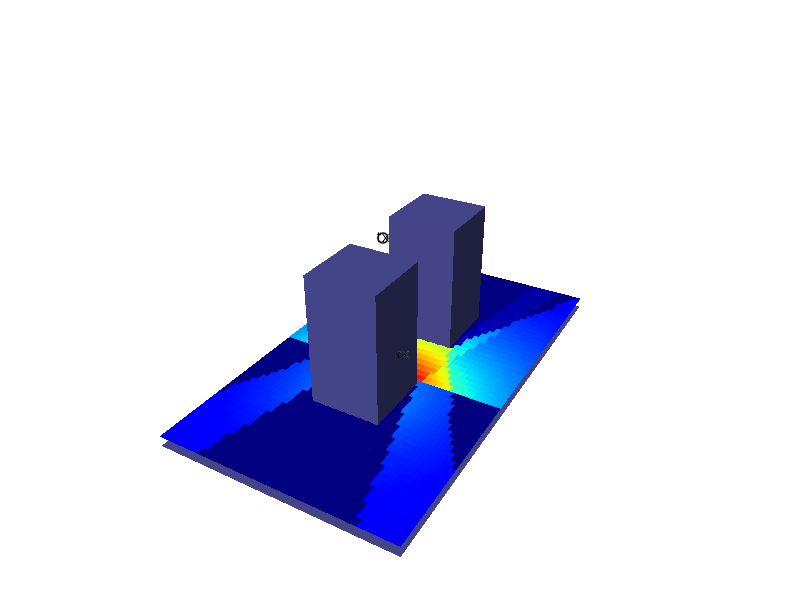

In [10]:
mesh_file = "two_buildings_with_ground.obj"  # Very simple scene with two buildings and one ground plane
mesh = TriangleMesh.load_obj(mesh_file)

canvas = mesh.plot()
tx = jnp.array([0.0, 4.9352, 22.0])
rx = jnp.array([0.0, 10.034, 1.50])

dplt.draw_markers(np.array([tx, rx]), ["tx", "rx"], canvas=canvas)

all_triangle_vertices = jnp.take(mesh.vertices, mesh.triangles, axis=0)

x_tri = all_triangle_vertices[..., 0]
y_tri = all_triangle_vertices[..., 1]

N = 50

x = jnp.linspace(x_tri.min(), x_tri.max(), N)
y = jnp.linspace(y_tri.min(), y_tri.max(), N)
X, Y = jnp.meshgrid(x, y)
Z = 1.5 * jnp.ones_like(X)
RX = jnp.stack((X, Y, Z), axis=-1)

power = jnp.zeros_like(X)

num_triangles = mesh.triangles.shape[0]

for order in trange(
    0, 3, leave=False
):  # You probably don't want to try order > 1 (too slow if testing all paths)
    # Prepare input arrays
    for path_candidates in tqdm(
        generate_all_path_candidates_chunks_iter(num_triangles, order, chunk_size=100),
        leave=False,
    ):
        num_path_candidates = path_candidates.shape[0]
        from_vertices = jnp.tile(tx, (N, N, num_path_candidates, 1))
        to_vertices = jnp.tile(
            jnp.expand_dims(RX, axis=-2), (1, 1, num_path_candidates, 1)
        )
        path_candidates = jnp.tile(path_candidates, (N, N, 1, 1))
        triangles = jnp.take(mesh.triangles, path_candidates, axis=0)
        triangle_vertices = jnp.take(mesh.vertices, triangles, axis=0)
        mirror_vertices = triangle_vertices[..., 0, :]
        mirror_normals = jnp.take(mesh.normals, path_candidates, axis=0)
        paths = image_method(
            from_vertices, to_vertices, mirror_vertices, mirror_normals
        )
        mask = triangles_contain_vertices_assuming_inside_same_plane(
            triangle_vertices,
            paths,
        )
        mask_1 = jnp.all(mask, axis=-1)
        full_paths = jnp.concatenate(
            (
                jnp.expand_dims(from_vertices, axis=-2),
                paths,
                jnp.expand_dims(to_vertices, axis=-2),
            ),
            axis=-2,
        )
        mask_2 = consecutive_vertices_are_on_same_side_of_mirrors(
            full_paths, mirror_vertices, mirror_normals
        )
        mask_2 = jnp.all(mask_2, axis=-1)
        ray_origins = full_paths[..., :-1, :]
        ray_directions = jnp.diff(full_paths, axis=-2)
        ray_origins = jnp.repeat(
            jnp.expand_dims(ray_origins, axis=-2), num_triangles, axis=-2
        )
        ray_directions = jnp.repeat(
            jnp.expand_dims(ray_directions, axis=-2), num_triangles, axis=-2
        )
        t, hit = rays_intersect_triangles(
            ray_origins,
            ray_directions,
            jnp.broadcast_to(all_triangle_vertices, (*ray_origins.shape, 3)),
        )
        intersect = (t < 0.999) & hit
        intersect = jnp.any(intersect, axis=(-1, -2))
        mask_2 = mask_2 & ~intersect
        mask = mask_1 & mask_2

        lengths = jnp.linalg.norm(full_paths, axis=-1).sum(axis=-1)
        power_per_path = 1.0 / (lengths * lengths)
        power_per_path *= mask.astype(power_per_path.dtype)

        # print(f"{power_per_path.shape = }")
        # print(f"{mask_1.shape = }")
        # print(f"{mask_2.shape = }")

        # print(lengths.shape)

        power += power_per_path.sum(axis=-1)


image = Image(power, interpolation="nearest", method="subdivide", cmap="jet")
image.transform = STTransform(
    scale=(abs(np.max(x) - np.min(x)) / N, abs(np.max(y) - np.min(y)) / N),
    translate=(np.min(x), np.min(y), 1.5),
)

view = dplt.view_from_canvas(canvas)
view.add(image)

canvas

In [11]:
from differt.plotting import process_matplotlib_kwargs

In [18]:
fig, ax = process_matplotlib_kwargs({})
x = np.linspace(0, 10)
y = np.linspace(0, 5.)
X, Y = np.meshgrid(x, y)
C = X ** 2 + Y ** 2
ax.pcolormesh(X, Y, C)

Error in callback <function _draw_all_if_interactive at 0x7f8002451360> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

<Figure size 640x480 with 1 Axes>